In [1]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)


In [2]:

import itertools
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from PIL import Image
from sklearn.metrics import classification_report, f1_score , confusion_matrix



In [3]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Rescaling, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, models, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import mixed_precision

mixed_precision.set_global_policy('mixed_float16')

print(tf.__version__)


2025-05-18 03:35:53.005891: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747539353.209669      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747539353.267834      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


2.18.0


In [4]:
dataset = {
             "train_data" : "/kaggle/input/indian-birds/Birds_25/train",
             "valid_data" : "/kaggle/input/indian-birds/Birds_25/valid",
          }

In [5]:


all_data = []
for path in dataset.values():
    data = {"imgpath": [] , "labels": [] }
    category = os.listdir(path)

    for folder in category:
        folderpath = os.path.join(path , folder)
        filelist = os.listdir(folderpath)
        for file in filelist:
            fpath = os.path.join(folderpath, file)
            data["imgpath"].append(fpath)
            data["labels"].append(folder)
        
        
    all_data.append(data.copy())
    data.clear()

    
    
train_df = pd.DataFrame(all_data[0] , index=range(len(all_data[0]['imgpath'])))
valid_df = pd.DataFrame(all_data[1] , index=range(len(all_data[1]['imgpath'])))



In [6]:

#Convert labels to numbers
lb = LabelEncoder()
train_df['encoded_labels'] = lb.fit_transform(train_df['labels'])
valid_df['encoded_labels'] = lb.fit_transform(valid_df['labels'])

In [7]:
valid_df , test_df = train_test_split(valid_df ,  train_size= 0.95 , shuffle=True, random_state=124)
valid_df = valid_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

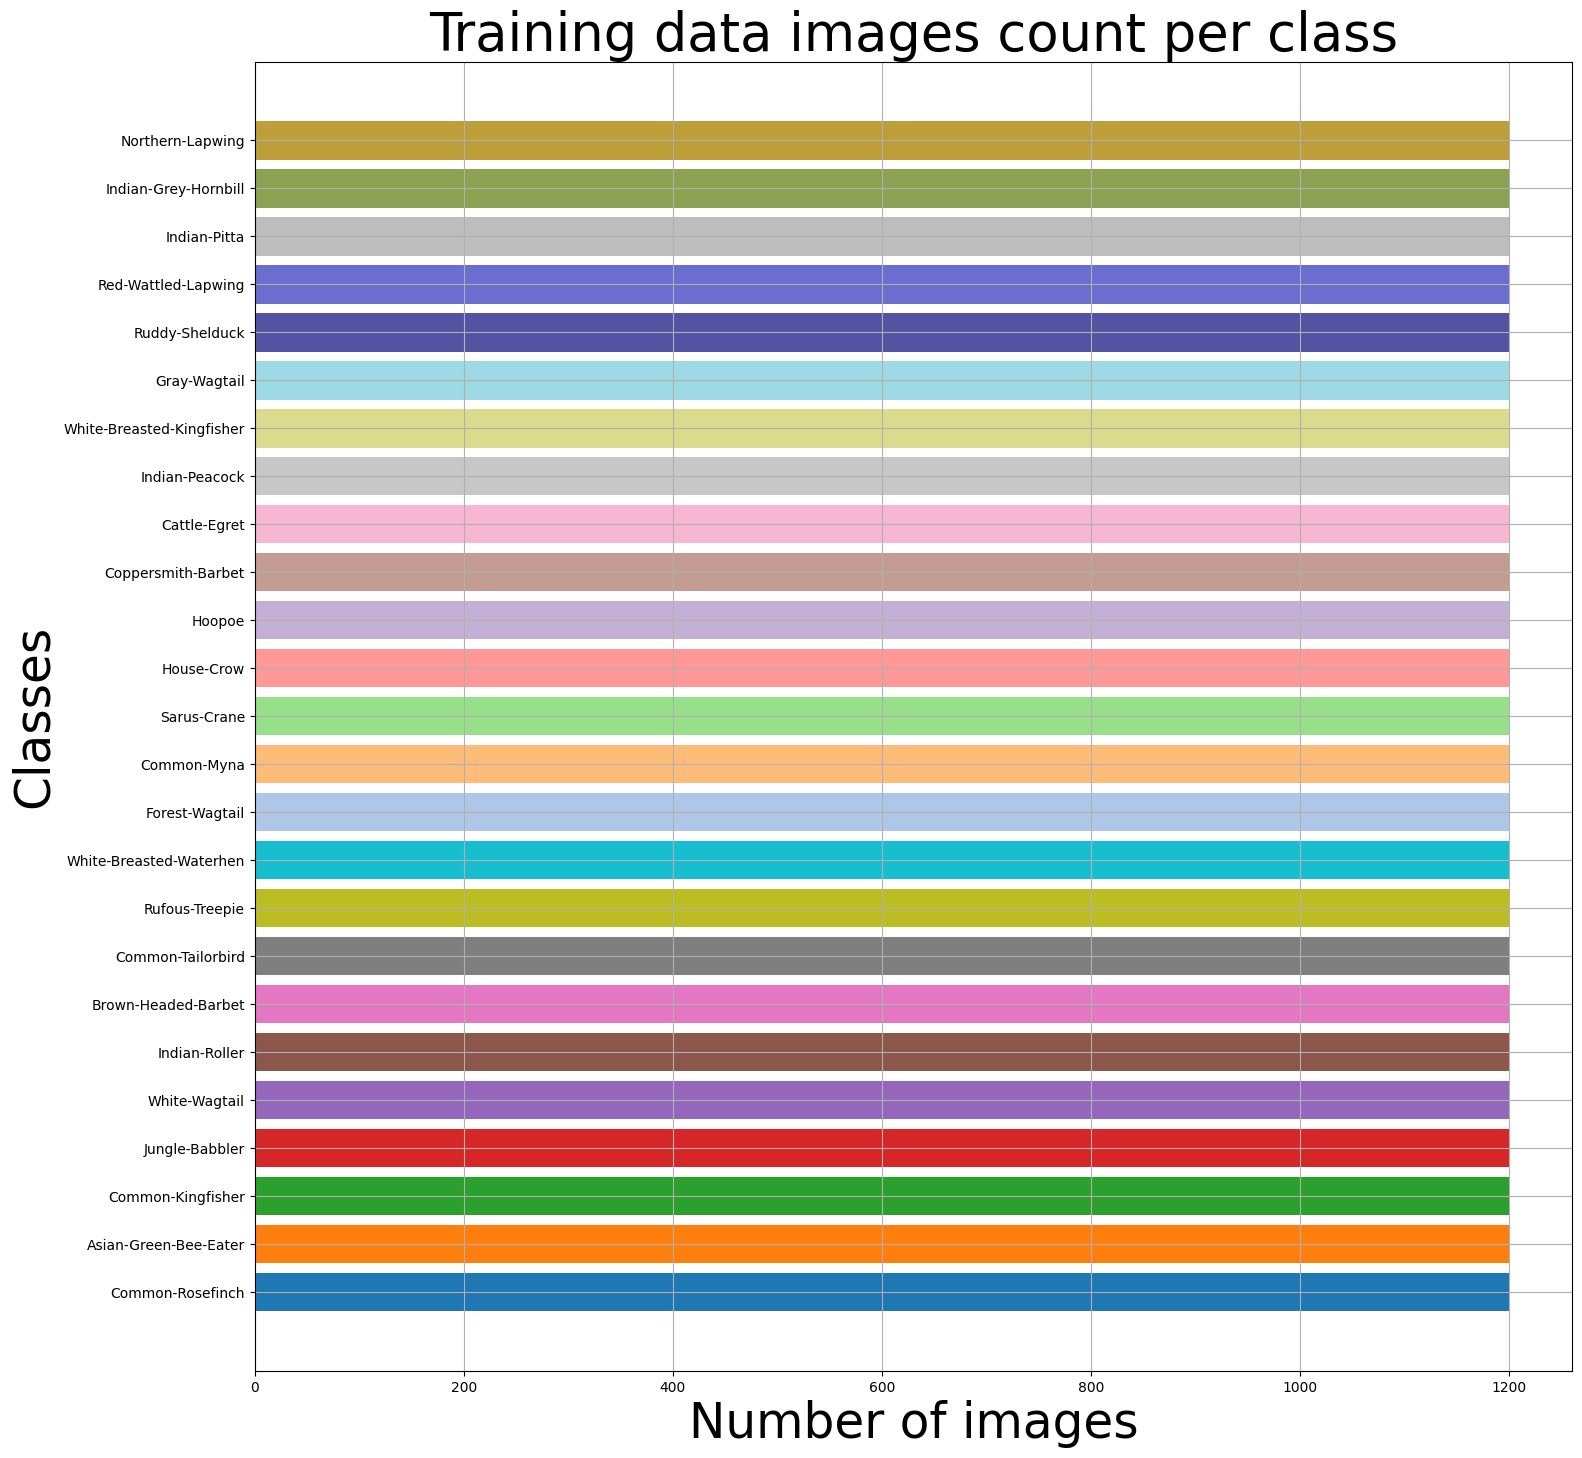

In [8]:
train  = train_df["labels"].value_counts()
label = train.tolist()
index = train.index.tolist()

colors = [
    "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd",
    "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf",
    "#aec7e8", "#ffbb78", "#98df8a", "#ff9896", "#c5b0d5",
    "#c49c94", "#f7b6d2", "#c7c7c7", "#dbdb8d", "#9edae5",
    "#5254a3", "#6b6ecf", "#bdbdbd", "#8ca252", "#bd9e39",
    "#ad494a", "#8c6d31", "#6b6ecf", "#e7ba52", "#ce6dbd",
    "#9c9ede", "#cedb9c", "#de9ed6", "#ad494a", "#d6616b",
    "#f7f7f7", "#7b4173", "#a55194", "#ce6dbd"
]



plt.figure(figsize=(17,17))
plt.title("Training data images count per class",fontsize=38)
plt.xlabel('Number of images', fontsize=35)
plt.ylabel('Classes', fontsize=35)
plt.barh(index,label, color=colors)
plt.grid(True)
plt.show()

In [9]:
train_df.sample(n=15, random_state=1)

imgpath  \
10747  /kaggle/input/indian-birds/Birds_25/train/Rufo...   
12573  /kaggle/input/indian-birds/Birds_25/train/Fore...   
29676  /kaggle/input/indian-birds/Birds_25/train/Nort...   
8856   /kaggle/input/indian-birds/Birds_25/train/Comm...   
21098  /kaggle/input/indian-birds/Birds_25/train/Indi...   
17458  /kaggle/input/indian-birds/Birds_25/train/Hoop...   
1476   /kaggle/input/indian-birds/Birds_25/train/Asia...   
5120   /kaggle/input/indian-birds/Birds_25/train/Whit...   
18338  /kaggle/input/indian-birds/Birds_25/train/Copp...   
28279  /kaggle/input/indian-birds/Birds_25/train/Indi...   
1684   /kaggle/input/indian-birds/Birds_25/train/Asia...   
20371  /kaggle/input/indian-birds/Birds_25/train/Catt...   
3608   /kaggle/input/indian-birds/Birds_25/train/Jung...   
13012  /kaggle/input/indian-birds/Birds_25/train/Fore...   
6793   /kaggle/input/indian-birds/Birds_25/train/Indi...   

                      labels  encoded_labels  
10747         Rufous-Treepie              20  
12573         Forest-Wagtail               8  
29676       Northern-Lapwing              17  
8856       Common-Tailorbird               6  
21098         Indian-Peacock              13  
17458                 Hoopoe              10  
1476   Asian-Green-Bee-Eater               0  
5120           White-Wagtail              24  
18338     Coppersmith-Barbet               7  
28279   Indian-Grey-Hornbill              12  
1684   Asian-Green-Bee-Eater               0  
20371           Cattle-Egret               2  
3608          Jungle-Babbler              16  
13012         Forest-Wagtail               8  
6793           Indian-Roller              15

In [10]:
print("----------Train-------------")
print(train_df[["imgpath", "labels"]].head(5))
print(train_df.shape)
print("--------Validation----------")
print(valid_df[["imgpath", "labels"]].head(5))
print(valid_df.shape)
print("----------Test--------------")
print(test_df[["imgpath", "labels"]].head(5))
print(test_df.shape)

----------Train-------------
                                             imgpath            labels
0  /kaggle/input/indian-birds/Birds_25/train/Comm...  Common-Rosefinch
1  /kaggle/input/indian-birds/Birds_25/train/Comm...  Common-Rosefinch
2  /kaggle/input/indian-birds/Birds_25/train/Comm...  Common-Rosefinch
3  /kaggle/input/indian-birds/Birds_25/train/Comm...  Common-Rosefinch
4  /kaggle/input/indian-birds/Birds_25/train/Comm...  Common-Rosefinch
(30000, 3)
--------Validation----------
                                             imgpath               labels
0  /kaggle/input/indian-birds/Birds_25/valid/Hous...           House-Crow
1  /kaggle/input/indian-birds/Birds_25/valid/Fore...       Forest-Wagtail
2  /kaggle/input/indian-birds/Birds_25/valid/Brow...  Brown-Headed-Barbet
3  /kaggle/input/indian-birds/Birds_25/valid/Red-...  Red-Wattled-Lapwing
4  /kaggle/input/indian-birds/Birds_25/valid/Gray...         Gray-Wagtail
(7125, 3)
----------Test--------------
                      

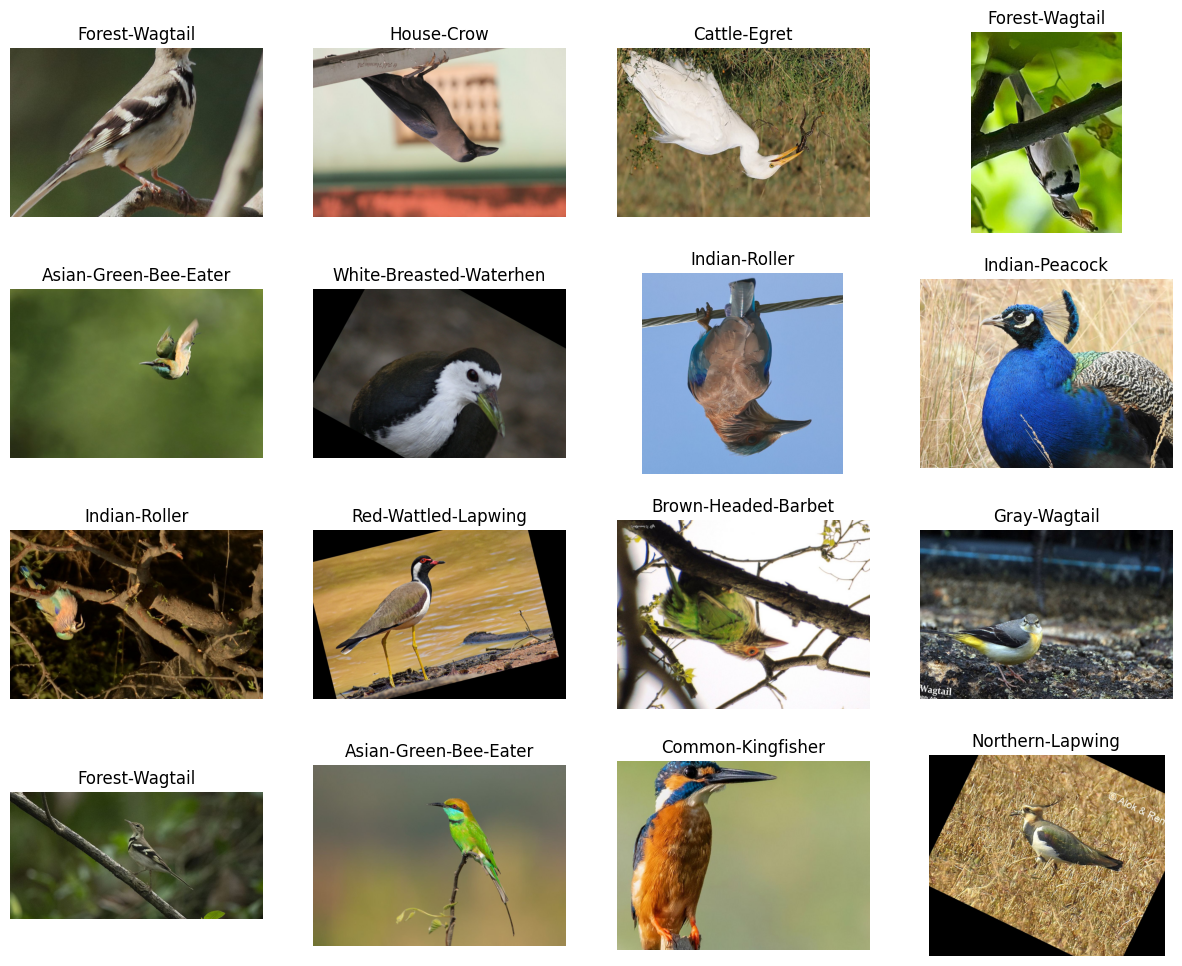

In [11]:
plt.figure(figsize=(15,12))
for i, row in valid_df.sample(n=16).reset_index().iterrows():
    plt.subplot(4,4,i+1)
    image_path = row['imgpath']
    image = Image.open(image_path)
    plt.imshow(image)
    plt.title(row["labels"])
    plt.axis('off')
plt.show()

In [12]:
%%time

BATCH_SIZE = 50
IMAGE_SIZE = (224, 224)


generator = ImageDataGenerator(
    preprocessing_function = tf.keras.applications.efficientnet.preprocess_input,
    # there could be image augmentation here
)

# Split the data into three categories.
train_images = generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='imgpath',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
)

val_images = generator.flow_from_dataframe(
    dataframe=valid_df,
    x_col='imgpath',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_images = generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='imgpath',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 30000 validated image filenames belonging to 25 classes.
Found 7125 validated image filenames belonging to 25 classes.
Found 375 validated image filenames belonging to 25 classes.
CPU times: user 618 ms, sys: 751 ms, total: 1.37 s
Wall time: 40.5 s


In [13]:
# Load the pretained model
pretrained_model = tf.keras.applications.EfficientNetB3(
    input_shape=(224, 224, 3),
    include_top=False, # we don`t need a pre-trained top layer (output layer)
    weights='imagenet',
    pooling='max'
)

# Freezing the layers of a pretrained neural network
for i, layer in enumerate(pretrained_model.layers):
    pretrained_model.layers[i].trainable = False

I0000 00:00:1747539409.886090      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1747539409.886825      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [14]:
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomContrast

num_classes = len(set(train_images.classes))


# Data Augmentation Step
augment = tf.keras.Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.1),
    RandomZoom(0.1),
    RandomContrast(0.1),
], name='AugmentationLayer')



inputs = layers.Input(shape = (224,224,3), name='inputLayer')
x = augment(inputs)
pretrain_out = pretrained_model(x, training = False)
x = layers.Dense(256)(pretrain_out)
x = layers.Activation(activation="relu")(x) 
x = BatchNormalization()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(num_classes)(x)
outputs = layers.Activation(activation="softmax", dtype=tf.float32, name='activationLayer')(x) # mixed_precision need separated Dense and Activation layers
model = Model(inputs=inputs, outputs=outputs)



model.compile(
    optimizer=Adam(0.0005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print(model.summary())

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ inputLayer (InputLayer)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cast_1 (Cast)                        │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ AugmentationLayer (Sequential)       │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb3 (Functional)          │ (None, 1536)                │      10,783,535 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         393,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 25)                  │           6,425 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cast_2 (Cast)                        │ (None, 25)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activationLayer (Activation)         │ (None, 25)                  │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,184,456 (42.67 MB)

 Trainable params: 400,409 (1.53 MB)

 Non-trainable params: 10,784,047 (41.14 MB)

None


In [15]:
history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=5,
    callbacks=[
        EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, mode='min')
    ]
)


#model.save_weights('./checkpoints/my_checkpoint.weights.h5')

Epoch 1/5


I0000 00:00:1747539447.062808      96 cuda_dnn.cc:529] Loaded cuDNN version 90300


600/600 ━━━━━━━━━━━━━━━━━━━━ 380s 576ms/step - accuracy: 0.6640 - loss: 1.2079 - val_accuracy: 0.9046 - val_loss: 0.3208 - learning_rate: 5.0000e-04
Epoch 2/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 243s 402ms/step - accuracy: 0.8620 - loss: 0.4653 - val_accuracy: 0.9231 - val_loss: 0.2604 - learning_rate: 5.0000e-04
Epoch 3/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 242s 399ms/step - accuracy: 0.8804 - loss: 0.4017 - val_accuracy: 0.9265 - val_loss: 0.2342 - learning_rate: 5.0000e-04
Epoch 4/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 244s 402ms/step - accuracy: 0.8915 - loss: 0.3600 - val_accuracy: 0.9263 - val_loss: 0.2380 - learning_rate: 5.0000e-04
Epoch 5/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 239s 395ms/step - accuracy: 0.8953 - loss: 0.3432 - val_accuracy: 0.9384 - val_loss: 0.2073 - learning_rate: 5.0000e-04


In [16]:
import os

# Ensure the directory exists
checkpoint_dir = './checkpoints'
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

# Now you can safely save the model weights
model.save_weights(os.path.join(checkpoint_dir, 'my_checkpoint.weights.h5'))


In [17]:
print(len(train_images))  # Number of batches
print(train_images.samples)  # Total number of images


600
30000


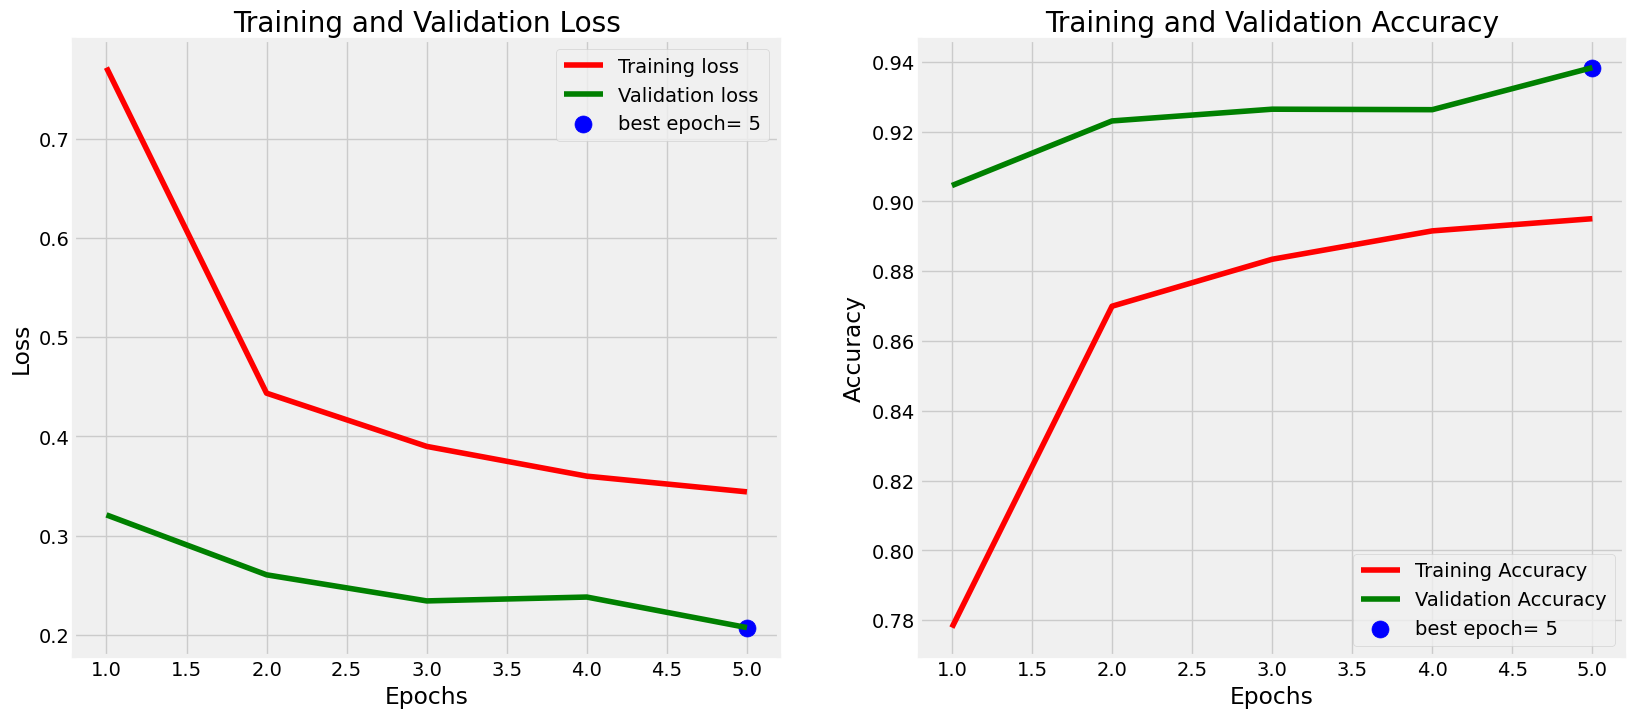

In [18]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [19]:
pretrained_model.trainable = True
for layer in pretrained_model.layers:
    if isinstance(layer, layers.BatchNormalization): # set BatchNorm layers as not trainable
        layer.trainable = False
        
# let`s see first 10 layers
for l in pretrained_model.layers[:10]:
    print(l.name, l.trainable)

model.compile(
    optimizer=Adam(0.00001), # fine tuning requires very little learning rate
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
# model.load_weights('./checkpoints/my_checkpoint')
print(model.summary())
history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=6,
    callbacks=[
        EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, mode='min')
    ]
)


#model.save_weights('./checkpoints/my_checkpoint')

input_layer False
rescaling False
normalization False
rescaling_1 False
stem_conv_pad False
stem_conv False
stem_bn False
stem_activation False
block1a_dwconv False
block1a_bn False


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ inputLayer (InputLayer)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cast_1 (Cast)                        │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ AugmentationLayer (Sequential)       │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb3 (Functional)          │ (None, 1536)                │      10,783,535 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         393,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 25)                  │           6,425 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cast_2 (Cast)                        │ (None, 25)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activationLayer (Activation)         │ (None, 25)                  │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,184,456 (42.67 MB)

 Trainable params: 400,409 (1.53 MB)

 Non-trainable params: 10,784,047 (41.14 MB)

None
Epoch 1/6
600/600 ━━━━━━━━━━━━━━━━━━━━ 273s 405ms/step - accuracy: 0.9052 - loss: 0.3161 - val_accuracy: 0.9434 - val_loss: 0.1865 - learning_rate: 1.0000e-05
Epoch 2/6
600/600 ━━━━━━━━━━━━━━━━━━━━ 245s 404ms/step - accuracy: 0.9086 - loss: 0.3018 - val_accuracy: 0.9441 - val_loss: 0.1822 - learning_rate: 1.0000e-05
Epoch 3/6
600/600 ━━━━━━━━━━━━━━━━━━━━ 241s 398ms/step - accuracy: 0.9062 - loss: 0.3037 - val_accuracy: 0.9436 - val_loss: 0.1797 - learning_rate: 1.0000e-05
Epoch 4/6
600/600 ━━━━━━━━━━━━━━━━━━━━ 231s 382ms/step - accuracy: 0.9104 - loss: 0.2890 - val_accuracy: 0.9455 - val_loss: 0.1776 - learning_rate: 1.0000e-05
Epoch 5/6
600/600 ━━━━━━━━━━━━━━━━━━━━ 231s 382ms/step - accuracy: 0.9140 - loss: 0.2825 - val_accuracy: 0.9454 - val_loss: 0.1767 - learning_rate: 1.0000e-05
Epoch 6/6
600/600 ━━━━━━━━━━━━━━━━━━━━ 241s 397ms/step - accuracy: 0.9131 - loss: 0.2808 - val_accuracy: 0.9461 - val_loss: 0.1748 - learning_rate: 1.0000e-05


In [33]:
import os

# Ensure the directory exists
checkpoint_dir = './checkpoints'
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

# Now you can safely save the model weights
model.save_weights(os.path.join(checkpoint_dir, 'my_checkpoint.weights.h5'))


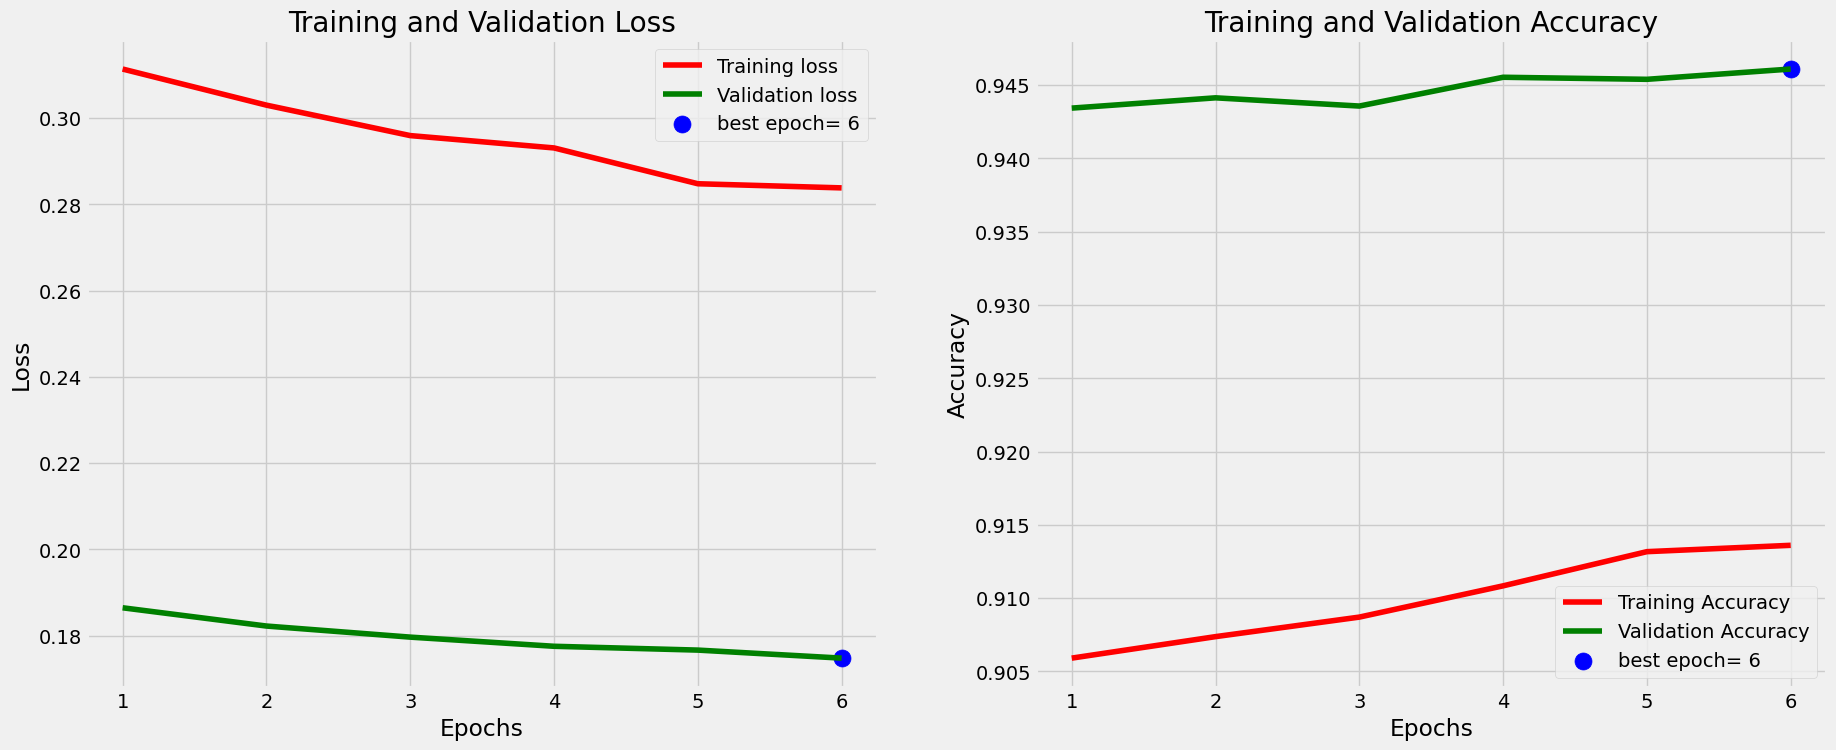

In [34]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [42]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Load base model
base_model = ResNet152V2(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze initially

# Augmentation block
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomZoom(0.1),
    layers.RandomTranslation(0.1, 0.1),
    layers.RandomContrast(0.2),
], name="data_augmentation")

# Build model
inputs = layers.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)

# Powerful classification head
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(num_classes, activation='softmax')(x)

model = models.Model(inputs, x)

# Compile
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Training phase 1: Train head only
history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=8,
    callbacks=[
        EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
        ReduceLROnPlateau(monitor="val_loss", factor=0.3, patience=2)
    ]
)

# Phase 2: Fine-tune entire model
base_model.trainable = True
for layer in base_model.layers:
    if isinstance(layer, layers.BatchNormalization):
        layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Fine-tune
history_finetune = model.fit(
    train_images,
    validation_data=val_images,
    epochs=10,
    callbacks=[
        EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
        ReduceLROnPlateau(monitor="val_loss", factor=0.3, patience=2)
    ]
)


234545216/234545216 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/8
600/600 ━━━━━━━━━━━━━━━━━━━━ 285s 420ms/step - accuracy: 0.3801 - loss: 2.2222 - val_accuracy: 0.8178 - val_loss: 0.5901 - learning_rate: 1.0000e-04
Epoch 2/8
600/600 ━━━━━━━━━━━━━━━━━━━━ 250s 413ms/step - accuracy: 0.7408 - loss: 0.8453 - val_accuracy: 0.8532 - val_loss: 0.4704 - learning_rate: 1.0000e-04
Epoch 3/8
600/600 ━━━━━━━━━━━━━━━━━━━━ 244s 403ms/step - accuracy: 0.7905 - loss: 0.6778 - val_accuracy: 0.8712 - val_loss: 0.4079 - learning_rate: 1.0000e-04
Epoch 4/8
600/600 ━━━━━━━━━━━━━━━━━━━━ 257s 424ms/step - accuracy: 0.8135 - loss: 0.6050 - val_accuracy: 0.8768 - val_loss: 0.3876 - learning_rate: 1.0000e-04
Epoch 5/8
600/600 ━━━━━━━━━━━━━━━━━━━━ 244s 403ms/step - accuracy: 0.8332 - loss: 0.5372 - val_accuracy: 0.8873 - val_loss: 0.3538 - learning_rate: 1.0000e-04
Epoch 6/8
600/600 ━━━━━━━━━━━━━━━━━━━━ 246s 406ms/step - accuracy: 0.8477 - loss: 0.4843 - val_accuracy: 0.8931 - val_loss: 0.3371 - learning_rate: 1.00

In [46]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Load the EfficientNetB3 model without the top classification layer
pretrained_model = EfficientNetB3(include_top=False, input_shape=(224, 224, 3), pooling='avg')

# Number of classes in the training dataset
num_classes = len(set(train_images.classes))

# Augmentation layer
augment = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.15),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
], name='AugmentationLayer')

# Define the input layer
inputs = layers.Input(shape=(224, 224, 3), name='inputLayer')

# Apply the augmentation
x = augment(inputs)

# Rescale the image pixel values to [0, 1]
x = layers.Rescaling(1./255)(x)

# Pass the image through the pretrained EfficientNetB3 model
x = pretrained_model(x, training=False)

# Add custom classification layers
x = layers.Dense(512)(x)
x = layers.LeakyReLU()(x)
x = Dropout(0.4)(x)
x = BatchNormalization()(x)

x = layers.Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)

x = layers.Dense(128, activation='relu')(x)

# Output layer with softmax activation for multi-class classification
x = layers.Dense(num_classes)(x)
outputs = layers.Activation("softmax", dtype=tf.float32, name='activationLayer')(x)

# Create the final model
model = Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Show the model summary
model.summary()

# Train the model
history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=5,
    callbacks=[
        EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, mode='min')
    ]
)

# Optionally save the model weights
# model.save_weights('./checkpoints/efficientnetb3_custom_checkpoint.h5')


Model: "functional_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ inputLayer (InputLayer)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cast_24 (Cast)                       │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ AugmentationLayer (Sequential)       │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_16 (Rescaling)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb3 (Functional)          │ (None, 1536)                │      10,783,535 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_40 (Dense)                     │ (None, 512)                 │         786,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_24 (LeakyReLU)           │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_29 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_20               │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_41 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_30 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_42 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_43 (Dense)                     │ (None, 25)                  │           3,225 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cast_25 (Cast)                       │ (None, 25)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activationLayer (Activation)         │ (None, 25)                  │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,739,976 (44.78 MB)

 Trainable params: 11,651,649 (44.45 MB)

 Non-trainable params: 88,327 (345.03 KB)

Epoch 1/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 641s 897ms/step - accuracy: 0.6447 - loss: 1.2747 - val_accuracy: 0.4511 - val_loss: 2.3989 - learning_rate: 5.0000e-04
Epoch 2/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 530s 879ms/step - accuracy: 0.9383 - loss: 0.2181 - val_accuracy: 0.9592 - val_loss: 0.1361 - learning_rate: 5.0000e-04
Epoch 3/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 533s 884ms/step - accuracy: 0.9530 - loss: 0.1622 - val_accuracy: 0.9505 - val_loss: 0.1800 - learning_rate: 5.0000e-04
Epoch 4/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 528s 876ms/step - accuracy: 0.9548 - loss: 0.1596 - val_accuracy: 0.9700 - val_loss: 0.1044 - learning_rate: 5.0000e-04
Epoch 5/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 528s 876ms/step - accuracy: 0.9668 - loss: 0.1205 - val_accuracy: 0.9721 - val_loss: 0.0921 - learning_rate: 5.0000e-04


In [48]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.10789
Test Accuracy: 97.07%


In [49]:
y_true = test_images.classes
y_pred = np.argmax(model.predict(test_images), axis = 1)
f1 = f1_score(y_true, y_pred, average='macro')
print("F1 Score:", f1)
print(classification_report(y_true, y_pred, target_names=test_images.class_indices.keys()))

8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 952ms/step
F1 Score: 0.9735552245009768
                           precision    recall  f1-score   support

    Asian-Green-Bee-Eater       0.92      1.00      0.96        12
      Brown-Headed-Barbet       0.92      0.92      0.92        13
             Cattle-Egret       0.95      0.95      0.95        19
        Common-Kingfisher       0.95      1.00      0.98        21
              Common-Myna       1.00      1.00      1.00        15
         Common-Rosefinch       0.79      1.00      0.88        15
        Common-Tailorbird       1.00      0.83      0.90        23
       Coppersmith-Barbet       1.00      0.94      0.97        16
           Forest-Wagtail       1.00      1.00      1.00        17
             Gray-Wagtail       1.00      1.00      1.00        10
                   Hoopoe       1.00      1.00      1.00        12
               House-Crow       1.00      1.00      1.00        18
     Indian-Grey-Hornbill       0.93      0.93      0.93   

In [50]:
classes = dict(zip(test_images.class_indices.values(), test_images.class_indices.keys()))
Predictions = pd.DataFrame({"Image Index" : list(range(len(test_images.labels))), 
                            "Test Labels" : test_images.labels, 
                            "Test Classes" : [classes[i] for i in test_images.labels],
                            "Prediction Labels" : y_pred,
                            "Prediction Classes" : [classes[i] for i in y_pred],
                            "Path": test_images.filenames,
                            "Prediction Probability" : [x for x in np.asarray(tf.reduce_max(model.predict(test_images), axis = 1))]
                           })
Predictions.head(8)

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 281ms/step


Image Index  Test Labels             Test Classes  Prediction Labels  \
0            0           14             Indian-Pitta                 14   
1            1            6        Common-Tailorbird                  6   
2            2           23  White-Breasted-Waterhen                 23   
3            3           10                   Hoopoe                 10   
4            4           23  White-Breasted-Waterhen                 23   
5            5           19           Ruddy-Shelduck                 19   
6            6           11               House-Crow                 11   
7            7           13           Indian-Peacock                 13   

        Prediction Classes                                               Path  \
0             Indian-Pitta  /kaggle/input/indian-birds/Birds_25/valid/Indi...   
1        Common-Tailorbird  /kaggle/input/indian-birds/Birds_25/valid/Comm...   
2  White-Breasted-Waterhen  /kaggle/input/indian-birds/Birds_25/valid/Whit...   
3                   Hoopoe  /kaggle/input/indian-birds/Birds_25/valid/Hoop...   
4  White-Breasted-Waterhen  /kaggle/input/indian-birds/Birds_25/valid/Whit...   
5           Ruddy-Shelduck  /kaggle/input/indian-birds/Birds_25/valid/Rudd...   
6               House-Crow  /kaggle/input/indian-birds/Birds_25/valid/Hous...   
7           Indian-Peacock  /kaggle/input/indian-birds/Birds_25/valid/Indi...   

   Prediction Probability  
0                0.936490  
1                1.000000  
2                0.999385  
3                1.000000  
4                1.000000  
5                0.998664  
6                0.999965  
7                0.999990

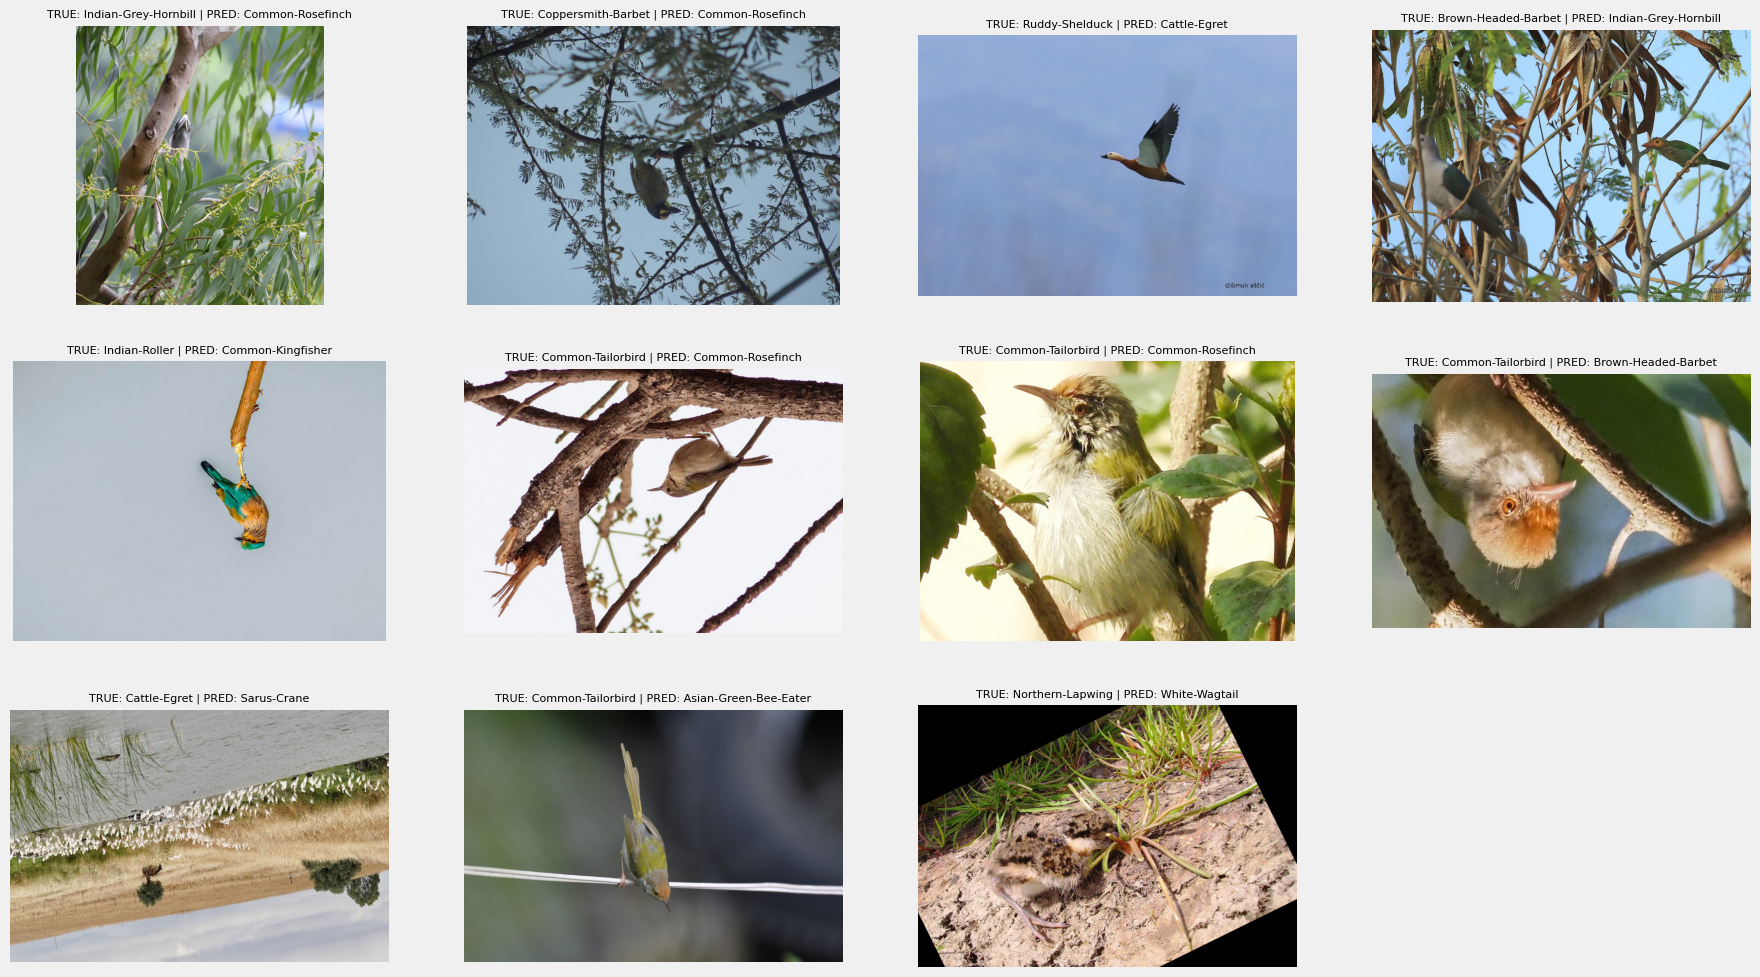

In [51]:
plt.figure(figsize=(20,20))
for i, row in Predictions[Predictions["Test Labels"] != Predictions["Prediction Labels"]].sort_values("Prediction Probability").tail(20).reset_index().iterrows():
    plt.subplot(5,4,i+1)
    image_path = row['Path']
    image = Image.open(image_path)
    plt.imshow(image)
    plt.title(f'TRUE: {row["Test Classes"]} | PRED: {row["Prediction Classes"]}', fontsize=8)
    plt.axis('off')
    
plt.show()

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 309ms/step


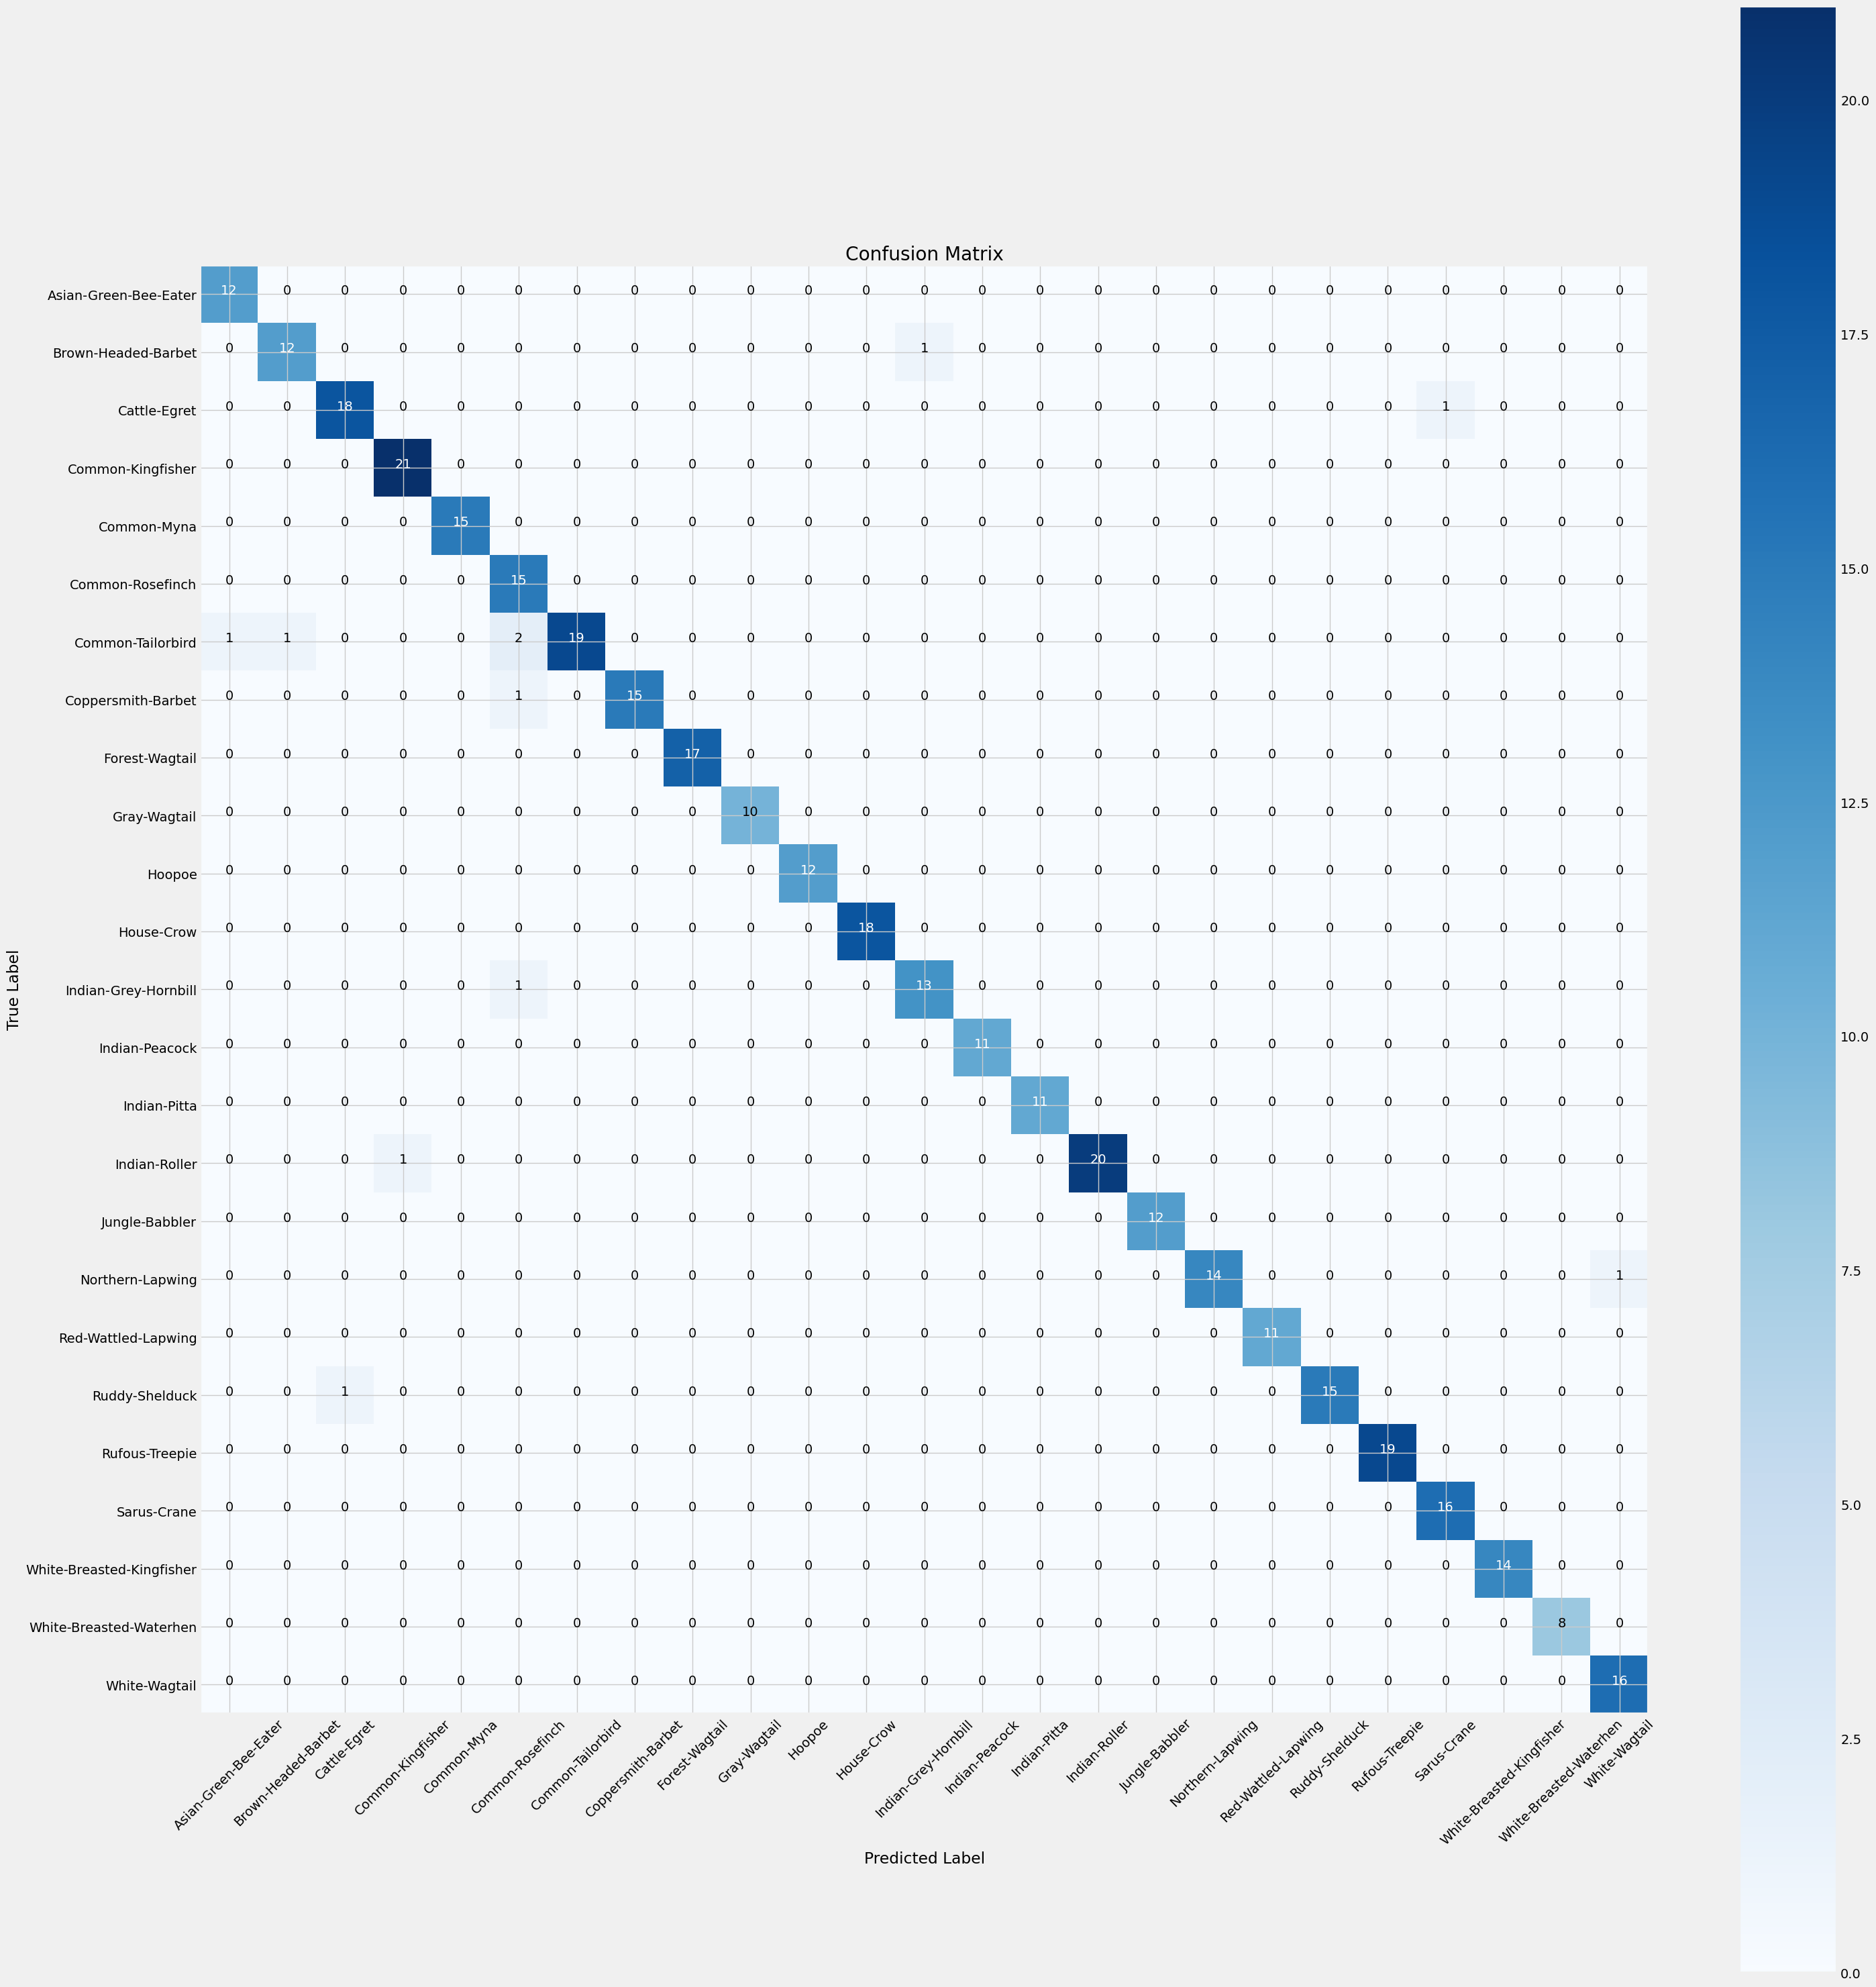

In [52]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix

# Predict using model.predict() instead of predict_generator()
preds = model.predict(test_images)  # ✅ This works for generators now
y_pred = np.argmax(preds, axis=1)

# Get class labels
g_dict = test_images.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_images.classes, y_pred)

plt.figure(figsize=(30, 30))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
             horizontalalignment='center',
             color='white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()
